In [1]:
import json

import numpy as np
import matplotlib.pylab as plt

from lattice_translocators.generators.Translocator import Translocator

from lattice_translocators.engines.MultistateSymmetricExtruder import MultistateSymmetricExtruder

# Extrusion dictionary

In [2]:
with open("uniform_dict_multistate.json", 'r') as dict_file:
    paramdict = json.load(dict_file)


In [3]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [4]:
# Work with a single type of monomers (A, assigned to type index 0)
type_list = ['A']

monomer_types = type_list.index('A') * np.ones(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [5]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict['LEF_lifetime']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_lifetime['A'], CTCF_facestall['A'])

243.41412012644878 1.0


# Making extruders

In [6]:
# Create some CTCF boundary sites
tad_size = 20 # in monomers

ctcf_left_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)
ctcf_right_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)

In [7]:
translocator = Translocator(MultistateSymmetricExtruder,
                            type_list, 
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict)

# Running the simulation

## State equilibration

In [8]:
LEF_states = []

for _ in range(paramdict['steps']):
    translocator.engine.step()
    LEF_states.append(translocator.engine.lef_states.copy())

In [9]:
LEF_states = np.asarray(LEF_states)
state_counts = np.zeros((len(LEF_states), 5))

for i in range(5):
    state_counts[:, i] = np.count_nonzero(LEF_states==i, axis=1)

In [10]:
states = ['R'] + list(paramdict['LEF_states'].keys())

mean_lifetimes = np.zeros(len(states))

for state_id in range(len(states)):
    for lef in range(translocator.engine.num_LEF):
        transitions = np.diff(LEF_states[:, lef] == state_id)
        ids = np.flatnonzero(transitions)

        if LEF_states[ids[0], lef] == state_id:
            binding_events = [ids[2*i+1+bool(state_id)]- ids[2*i+bool(state_id)] for i in range(len(ids)//2-1)]
        else:
            binding_events = [ids[2*i+2-bool(state_id)]- ids[2*i+1-bool(state_id)] for i in range(len(ids)//2-1)]

        mean_lifetimes[state_id] += sum(binding_events) / len(binding_events) / float(translocator.engine.num_LEF)


In [11]:

for state_id, state in enumerate(states):
    print("Mean %s lifetime: %.2f s" % (state[-1], mean_lifetimes[state_id]))

Mean R lifetime: 1338.55 s
Mean N lifetime: 79.04 s
Mean B lifetime: 32.86 s
Mean P lifetime: 69.83 s
Mean W lifetime: 44.77 s


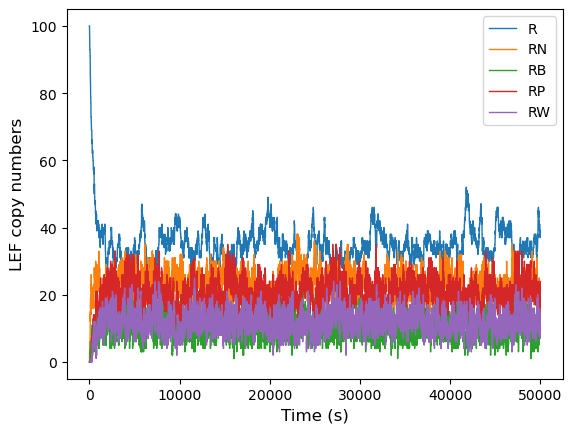

In [12]:
plt.plot(state_counts, lw=1)
plt.legend(states, loc='best')
          
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('LEF copy numbers', fontsize=12)

plt.show()

## Production run

In [13]:
translocator.run(period=1)

In [14]:
hist = []
frac_bound_LEFs = np.zeros(paramdict['steps'])

for i, lef_pos in enumerate(translocator.lef_trajectory):
    frac_bound_LEFs[i] = len(lef_pos) / float(translocator.engine.num_LEF)

    hist.extend(lef_pos)

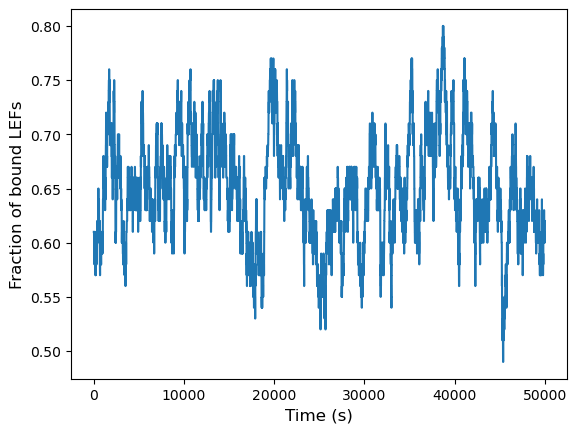

In [15]:
plt.plot(frac_bound_LEFs)
          
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Fraction of bound LEFs', fontsize=12)

plt.show()

# Kymograph Analysis

In [16]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset, sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

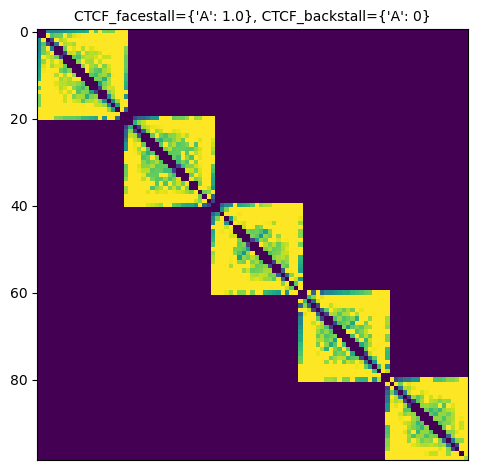

In [17]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_facestall=%s, CTCF_backstall=%s' % (paramdict['CTCF_facestall'],
                                                    paramdict['CTCF_backstall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
